In [1219]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

In [1091]:
emb_dim=100

In [966]:
def load_facts(filename):
    facts=[]
    for line in open(filename):
        line=line.strip().split(',')
        fact=[]
        if line[0]=='not':
            fact.append(True)
            line=line[1:]
        else:
            fact.append(False)
        fact.append(line[0])
        fact.append(line[1:])
        facts.append(fact)
    return facts
        

In [1310]:
class Constants(nn.Module):
    def __init__(self, constants,emb_dim):
        super(Constants, self).__init__()
        self.symbol2id=dict()
        self.id2symbol=dict()
        for i,s in enumerate(constants):
            self.symbol2id[s]=i
            self.id2symbol[i]=s
        self.embeddings = nn.Embedding(len(self.symbol2id), emb_dim)
    def forward(self,constants):
        constant_id=[]
        for c in constants:
            constant_id.append(self.symbol2id[c])
        embs=self.embeddings(Variable(torch.LongTensor(constant_id)))
        embs=torch.cat(embs).view(1,-1)
        return embs

In [1311]:
class Predicate(nn.Module):
    def __init__(self, name, variable_count, emb_dim):
        super(Predicate, self).__init__()
        self.name=name
        self.variable_count=variable_count
        self.emb_dim=emb_dim
        m=variable_count*emb_dim
        self.variable_count=variable_count
        self.W=Variable(torch.randn(m, emb_dim, m), requires_grad=True)
        self.V=Variable(torch.randn(m, emb_dim), requires_grad=True)
        self.B=Variable(torch.randn(emb_dim), requires_grad=True)
        self.u=Variable(torch.randn(emb_dim), requires_grad=True)
    def forward(self, embs, negation):
        m=self.variable_count*self.emb_dim
        W=self.W.view(m,-1)
        output=torch.mm(embs,W)
        output=output.view(-1,m)
        output=torch.mm(output,embs.view(-1,1))
        output=output.view(1,-1)
        output=output.add(torch.mm(embs,self.V))
        output=output.add(self.B)
        output=output.view(-1)
        output=torch.tanh(output)
        output=torch.mul(output,self.u).sum()
        output=torch.sigmoid(output)
        if negation:
            output=1.0-output
        return output

In [1330]:
class LTN2(nn.Module):
    def __init__(self, emb_dim, constants, predicates):
        super(LTN2, self).__init__()
        self.emb_dim=emb_dim
        self.Constants=Constants(constants, emb_dim)
        self.Predicates=dict()
        for name,n in predicates:
            self.Predicates[name]=Predicate(name,n,emb_dim)
    def forward(self, clause):
        predicate_results=[]
        Ans=None
        for predicate in clause:
            negation=predicate[0]
            name=predicate[1]
            constants=predicate[2]
            embs=self.Constants.forward(constants)
            output=self.Predicates[name].forward(embs,negation)
            predicate_results.append(output)
            if Ans is None or Ans.data.numpy()[0]<output.data.numpy()[0]:
                Ans=output
#         predicate_results=Variable(torch.FloatTensor(predicate_results))
#         return predicate_results[0]
        return torch.log(Ans),Ans
    def parameters(self):
        results=list(self.Constants.parameters())
        for name in self.Predicates:
            results+=list(self.Predicates[name].parameters())
        return results

In [1333]:
facts1=load_facts('./facts1.txt')
facts2=load_facts('./facts2.txt')
facts=facts1+facts2
ltn=LTN2(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
ltn.forward(clause=facts[0:1])

(Variable containing:
 -1.3209
 [torch.FloatTensor of size 1], Variable containing:
  0.2669
 [torch.FloatTensor of size 1])

  0%|          | 0/2000 [00:00<?, ?it/s]

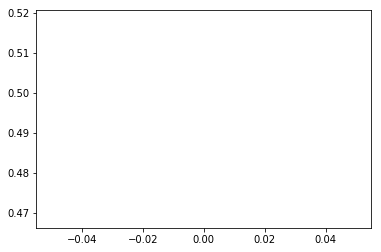

  0%|          | 1/2000 [00:01<37:21,  1.12s/it]

[False, 'S', ['a']]
0.319781
[False, 'S', ['f']]
1.61787e-06
[True, 'S', ['b']]
0.0685193
[True, 'S', ['c']]
0.000962138
[True, 'S', ['d']]
0.0
[True, 'S', ['g']]
0.000148773
[False, 'F', ['a', 'b']]
0.0025197
[False, 'F', ['a', 'e']]
0.0152733
[False, 'F', ['a', 'f']]
0.792803
[False, 'F', ['e', 'f']]
0.0147101
[False, 'F', ['g', 'h']]
0.0531988
[True, 'F', ['a', 'd']]
0.402774
[True, 'F', ['a', 'h']]
0.932851
[True, 'F', ['b', 'd']]
0.00656688
[True, 'F', ['c', 'g']]
4.76837e-07
[True, 'F', ['c', 'h']]
0.021305
[True, 'F', ['d', 'e']]
0.0
[True, 'F', ['d', 'f']]
0.326539
[True, 'F', ['d', 'g']]
1.28746e-05
[True, 'F', ['f', 'g']]
0.844532
[True, 'F', ['f', 'h']]
0.15214
[False, 'C', ['a']]
0.00340126
[True, 'C', ['b']]
4.87566e-05
[True, 'C', ['d']]
0.0
[False, 'S', ['i']]
1.28265e-06
[True, 'S', ['j']]
0.0186088
[True, 'S', ['l']]
0.776143
[True, 'S', ['m']]
2.38419e-07
[False, 'F', ['i', 'm']]
0.642201
[False, 'F', ['k', 'l']]
0.00132768
[False, 'F', ['m', 'n']]
0.00012396
[True, '

  5%|▌         | 100/2000 [01:06<20:59,  1.51it/s]

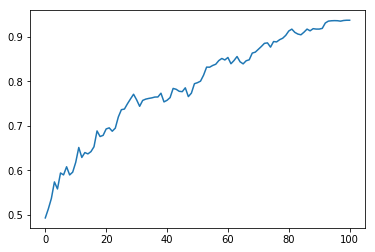

  5%|▌         | 101/2000 [01:07<21:05,  1.50it/s]

[False, 'S', ['f']]
3.00347e-09
[True, 'S', ['g']]
0.000226319
[False, 'S', ['i']]
2.65836e-06
[False, 'F', ['m', 'n']]
9.32503e-11
4


 10%|█         | 200/2000 [02:16<20:32,  1.46it/s]

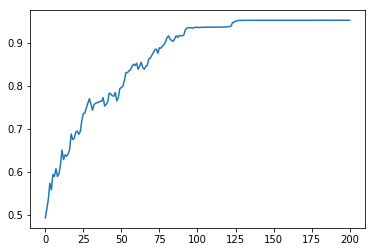

 10%|█         | 201/2000 [02:17<20:33,  1.46it/s]

[False, 'S', ['f']]
6.82857e-06
[False, 'S', ['g']]
0.00419558
[False, 'F', ['m', 'n']]
4.85356e-06
3


 15%|█▌        | 300/2000 [03:23<19:13,  1.47it/s]

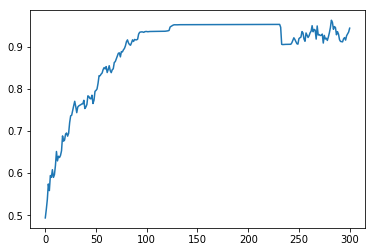

 15%|█▌        | 301/2000 [03:24<19:14,  1.47it/s]

[False, 'S', ['g']]
0.00180069
[False, 'F', ['i', 'm']]
0.0087309
[True, 'F', ['i', 'l']]
0.923864
[True, 'F', ['l', 'm']]
0.223871
4


 20%|██        | 400/2000 [45:11<3:00:45,  6.78s/it]

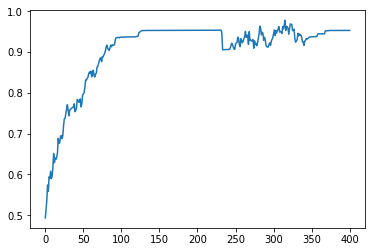

 20%|██        | 401/2000 [45:12<3:00:17,  6.76s/it]

[False, 'S', ['g']]
0.00114766
[False, 'F', ['i', 'j']]
1.58043e-05
[False, 'F', ['i', 'm']]
1.68828e-06
3


 25%|██▌       | 500/2000 [46:41<2:20:05,  5.60s/it]

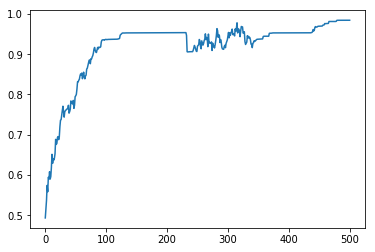

 25%|██▌       | 501/2000 [46:43<2:19:46,  5.59s/it]

[False, 'S', ['g']]
0.0049422
1


 30%|███       | 600/2000 [48:00<1:52:01,  4.80s/it]

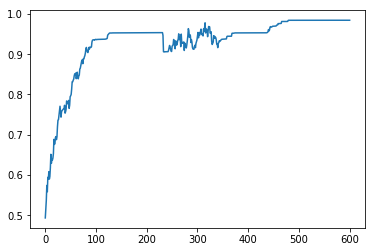

 30%|███       | 601/2000 [48:01<1:51:48,  4.79s/it]

[False, 'S', ['g']]
0.00240728
1


 33%|███▎      | 659/2000 [48:52<1:39:26,  4.45s/it]

In [ ]:
optimizor=torch.optim.Adam(ltn.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
errs=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0
    for f in facts:
        log,prob=ltn.forward(clause=[f])
        prob.backward(mone)
        total_probability+=prob.data.numpy()[0]
    optimizor.step()
    errs.append(total_probability/len(facts))
    if i%100==0:
        plt.plot(errs)
        plt.show()
        show_results(facts)

In [1336]:
def show_results(facts):
    wrong=0
    for f in facts:
        output=ltn.forward(clause=[f])
        if output[1].data.numpy()[0]>0.95:
            continue
        print(f)
        print(output[1].data.numpy()[0])
        wrong+=1
    print(wrong)

In [1195]:
show_results(facts)

[False, 'S', ['g']]
0.119012
[True, 'S', ['g']]
0.880988
2


In [1221]:
clauses=[
    [[True,'F','x','y'],[False,'F','y','x']]
]

In [1254]:
clauses=[
    [[False,'F','x','y']]
]

In [1255]:
def construct_training(clauses, variable, for_all):
    constants='abcdefghijklmn'
    new_clauses=[]
    if for_all:
        for clause in clauses:
            new_clauses+=replace_clause(clause,variable,constants)
    else:
        for clause in clauses:
            disjunction=[]
            for clause in replace_clause(clause,variable,constants):
                disjunction+=clause
            new_clauses.append(disjunction)
    return new_clauses

def replace_clause(clause,variable,constants):
    new_clauses=[]
    for constant in constants:
        new_clause=copy.deepcopy(clause)
        for i in range(len(new_clause)):
            for j in range(2,len(new_clause[i])):
                if new_clause[i][j]==variable:
                    new_clause[i][j]=constant
        new_clauses.append(new_clause)
    return new_clauses

In [1256]:
new=construct_training(clauses,'x',True)

In [1257]:
newnew=construct_training(new,'y',False)

In [1260]:
len(newnew[0])

14